In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os
import multiprocessing

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.keras import TqdmCallback
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPU 비활성화 (CPU 모드 강제)
num_cores = multiprocessing.cpu_count()

tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)


In [5]:
# drive.mount('/content/drive')

# rootdir = "/content/drive/MyDrive/인공지능 사관학교/Coding/7월/data"

# df = pd.read_csv(rootdir + '/processed_churn_data.csv')
df = pd.read_csv('../data/processed_churn_data.csv')

In [6]:
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod']

In [7]:
dummies = pd.get_dummies(df[cols], drop_first=True)

In [8]:
df = df.drop(cols, axis=1)

In [9]:
df = pd.concat([df, dummies], axis=1)

In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [13]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

- 기준모델 만들기

In [14]:
model = keras.models.Sequential([
    keras.layers.Input((23,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

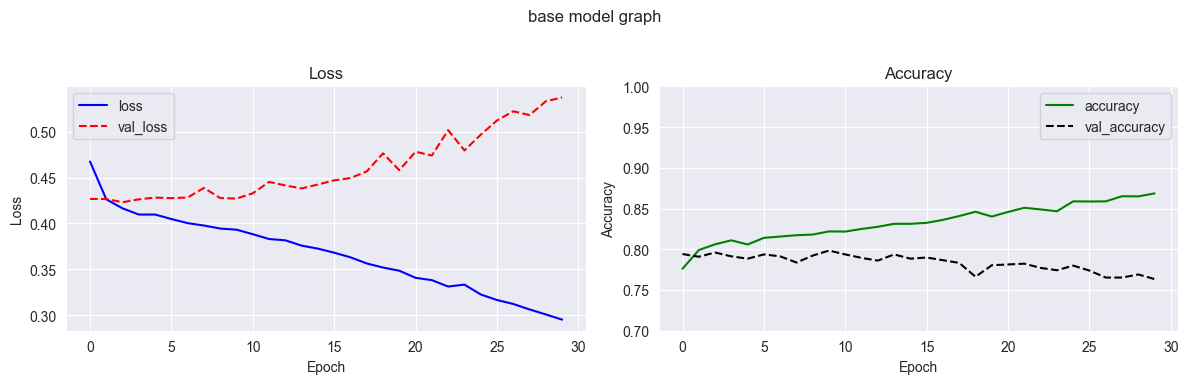

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('base model graph')

# Loss 그래프
axes[0].plot(baseline_history.history['loss'], 'b-', label='loss')
axes[0].plot(baseline_history.history['val_loss'], 'r--', label='val_loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

# Accuracy 그래프
axes[1].plot(baseline_history.history['accuracy'], 'g-', label='accuracy')
axes[1].plot(baseline_history.history['val_accuracy'], 'k--', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.7, 1)
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- 작은 모델 만들기

In [18]:
smaller_model = keras.models.Sequential([
    keras.layers.Input((23,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
smaller_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
smaller_history = smaller_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

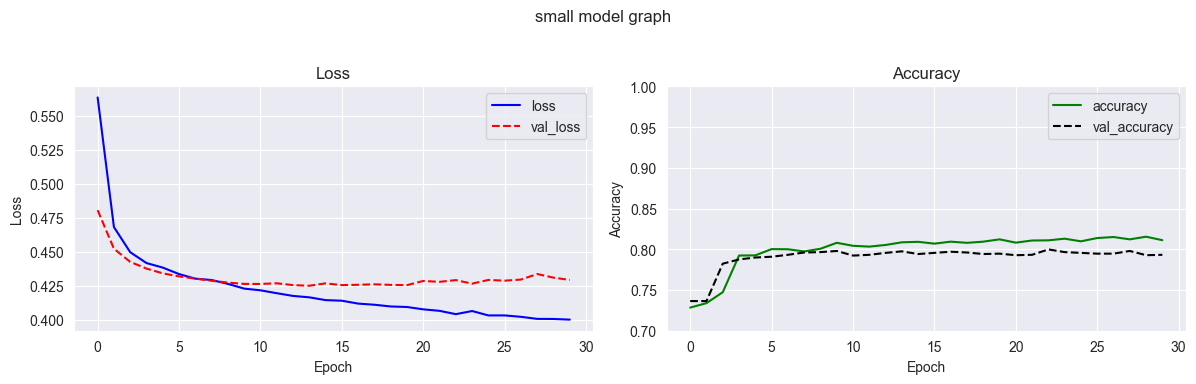

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('small model graph')

# Loss 그래프
axes[0].plot(smaller_history.history['loss'], 'b-', label='loss')
axes[0].plot(smaller_history.history['val_loss'], 'r--', label='val_loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

# Accuracy 그래프
axes[1].plot(smaller_history.history['accuracy'], 'g-', label='accuracy')
axes[1].plot(smaller_history.history['val_accuracy'], 'k--', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.7, 1)
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- 큰 모델 만들기

In [22]:
large_model = keras.models.Sequential([
    keras.layers.Input((23,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')
])

large_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,449 (345.50 KB)

 Trainable params: 88,449 (345.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
large_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [24]:
bigger_history = large_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

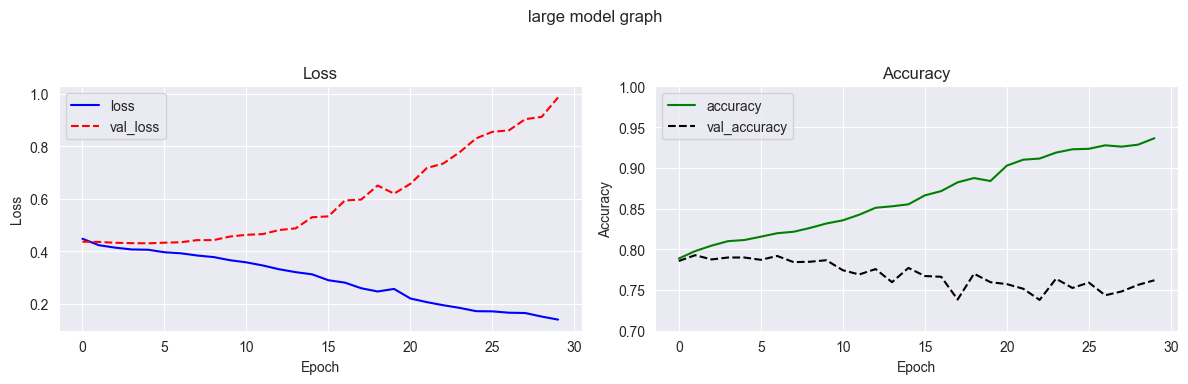

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('large model graph')

# Loss 그래프
axes[0].plot(bigger_history.history['loss'], 'b-', label='loss')
axes[0].plot(bigger_history.history['val_loss'], 'r--', label='val_loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

# Accuracy 그래프
axes[1].plot(bigger_history.history['accuracy'], 'g-', label='accuracy')
axes[1].plot(bigger_history.history['val_accuracy'], 'k--', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.7, 1)
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


- 손실 / 검증 비교

In [26]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(histories):
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    fig.suptitle('Model Training History')

    # Loss 그래프
    for name, history in histories:
        axes[0].plot(history.history['loss'], label=f'{name.title()} loss')
        axes[0].plot(history.history['val_loss'], '--', label=f'{name.title()} val_loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Loss')

    # Accuracy 그래프 (정확도 정보가 있을 때만)
    for name, history in histories:
        if 'accuracy' in history.history and 'val_accuracy' in history.history:
            axes[1].plot(history.history['accuracy'], label=f'{name.title()} accuracy')
            axes[1].plot(history.history['val_accuracy'], '--', label=f'{name.title()} val_accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0.7, 1)
    axes[1].legend()
    axes[1].set_title('Accuracy')

    plt.subplots_adjust(left=0.06, right=0.96, top=0.88, bottom=0.14, wspace=0.3)
    plt.show()


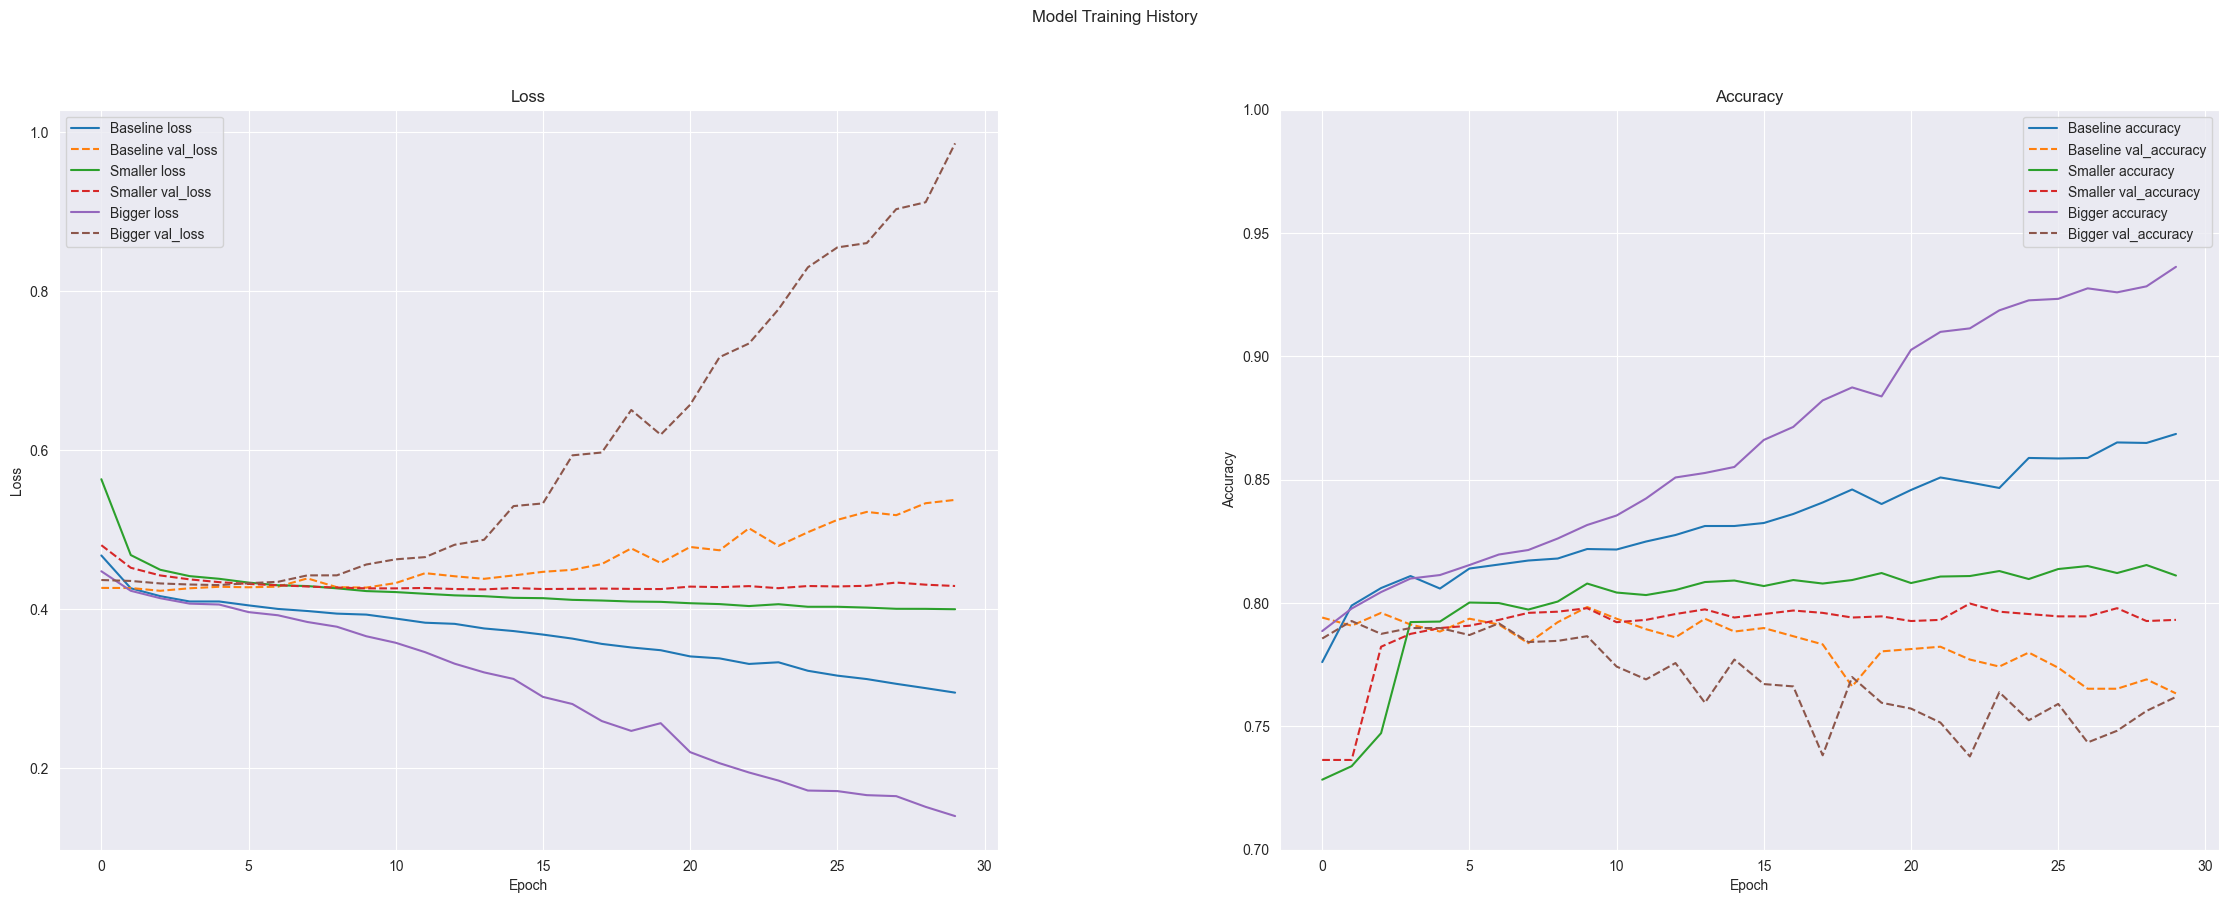

In [27]:
plot_loss_accuracy([
        ('baseline', baseline_history),
        ('smaller', smaller_history),
        ('bigger', bigger_history)
])

- 규제 추가해 비교

In [28]:
l2_model = keras.Sequential([
    keras.layers.Input((23,)),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(l2=0.001), activation='relu'),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(l2=0.001), activation='relu'),
    keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(l2=0.001), activation='relu'),

    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
l2_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [30]:
l2_history = l2_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

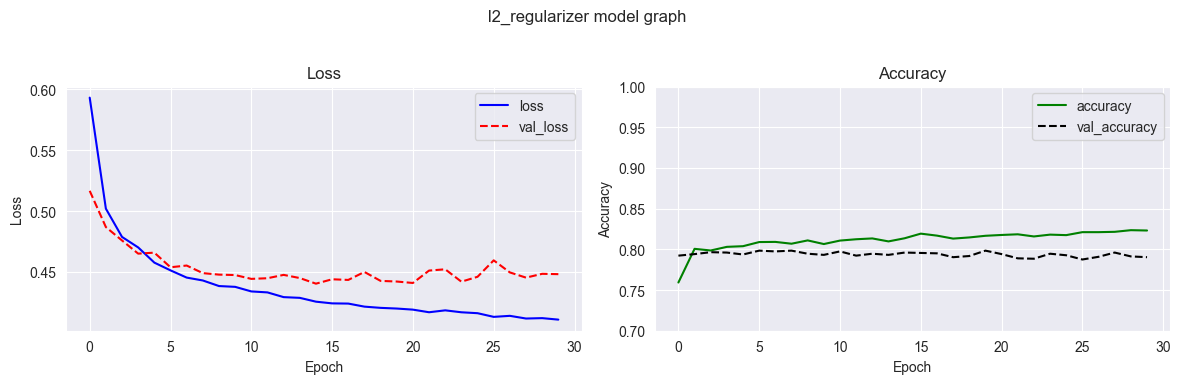

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('l2_regularizer model graph')

# Loss 그래프
axes[0].plot(l2_history.history['loss'], 'b-', label='loss')
axes[0].plot(l2_history.history['val_loss'], 'r--', label='val_loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

# Accuracy 그래프
axes[1].plot(l2_history.history['accuracy'], 'g-', label='accuracy')
axes[1].plot(l2_history.history['val_accuracy'], 'k--', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.7, 1)
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


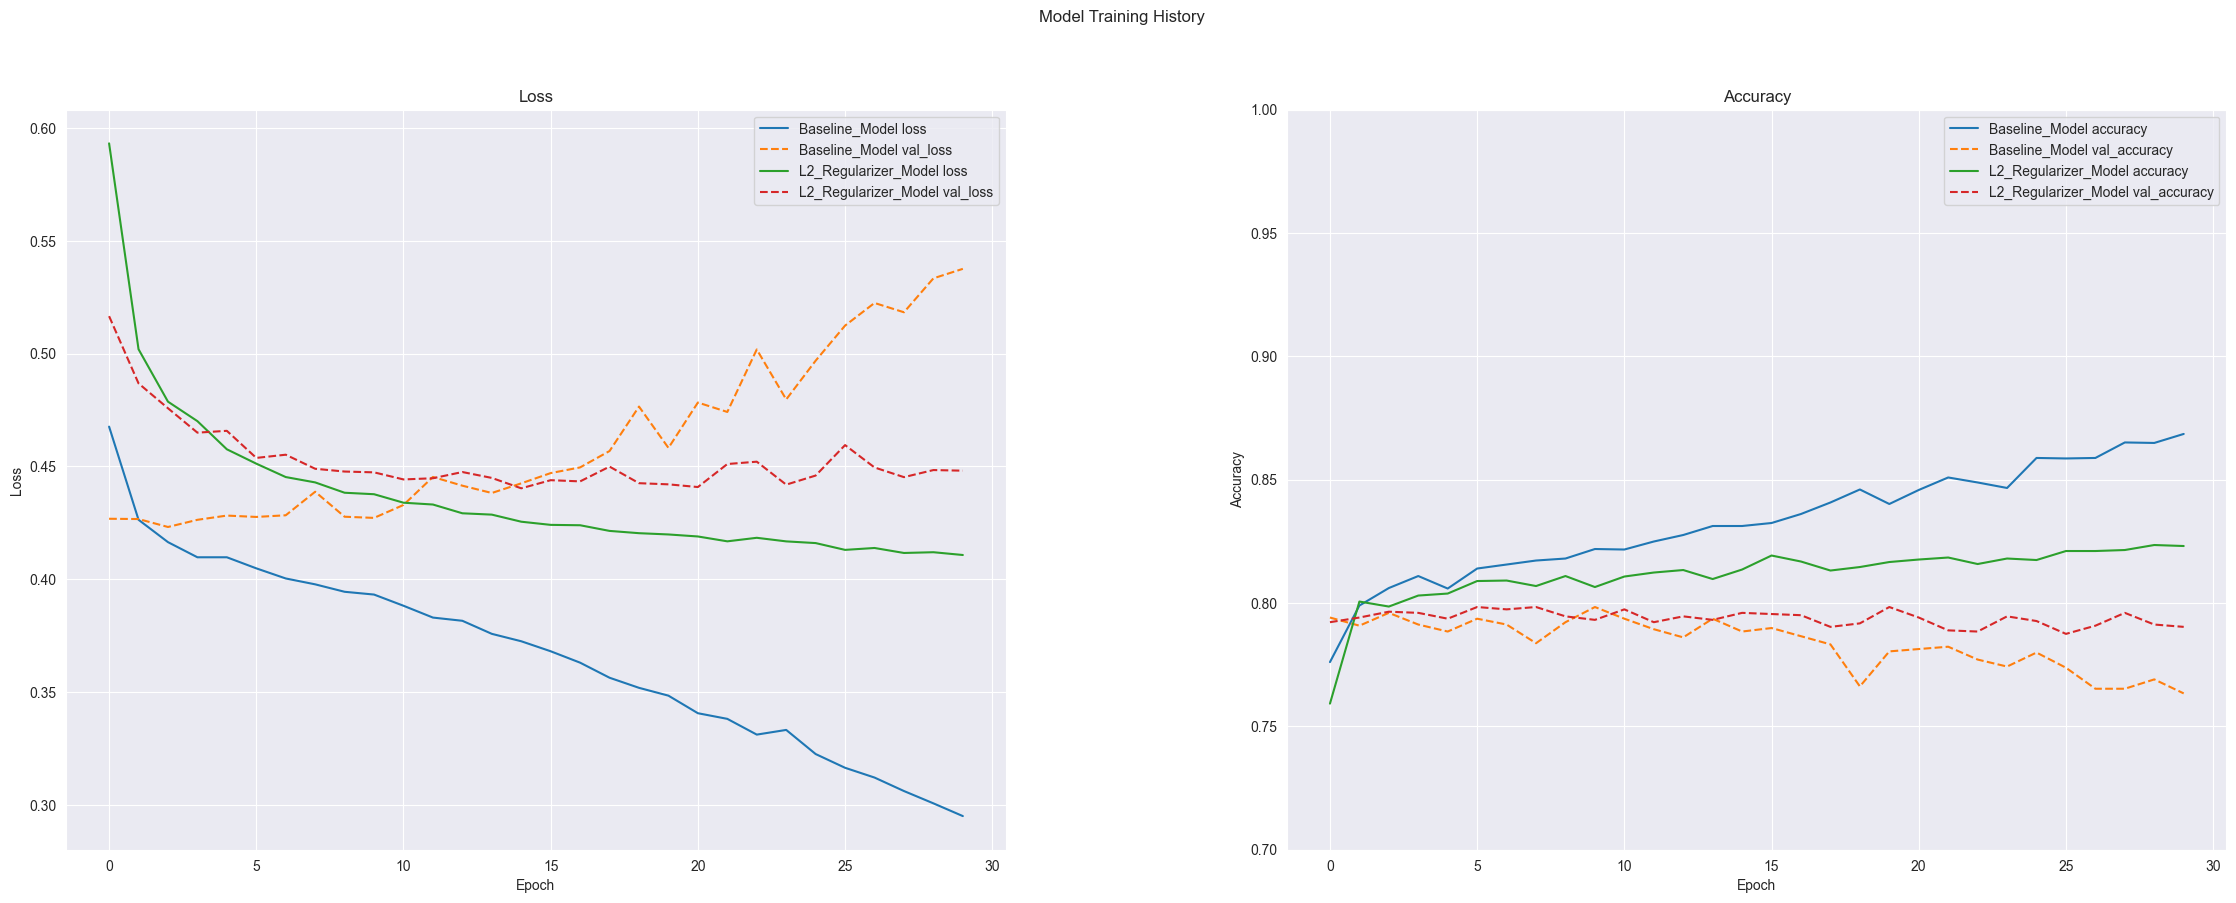

In [32]:
plot_loss_accuracy([
     ('baseline_model', baseline_history),
    ('l2_regularizer_model', l2_history)
])

- Dropout 추가해 비교

In [33]:
dpt_model = keras.Sequential([
    keras.layers.Input((23,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,809 (30.50 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
dpt_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
dropout_history = dpt_model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=0,
    callbacks=[TqdmCallback()]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

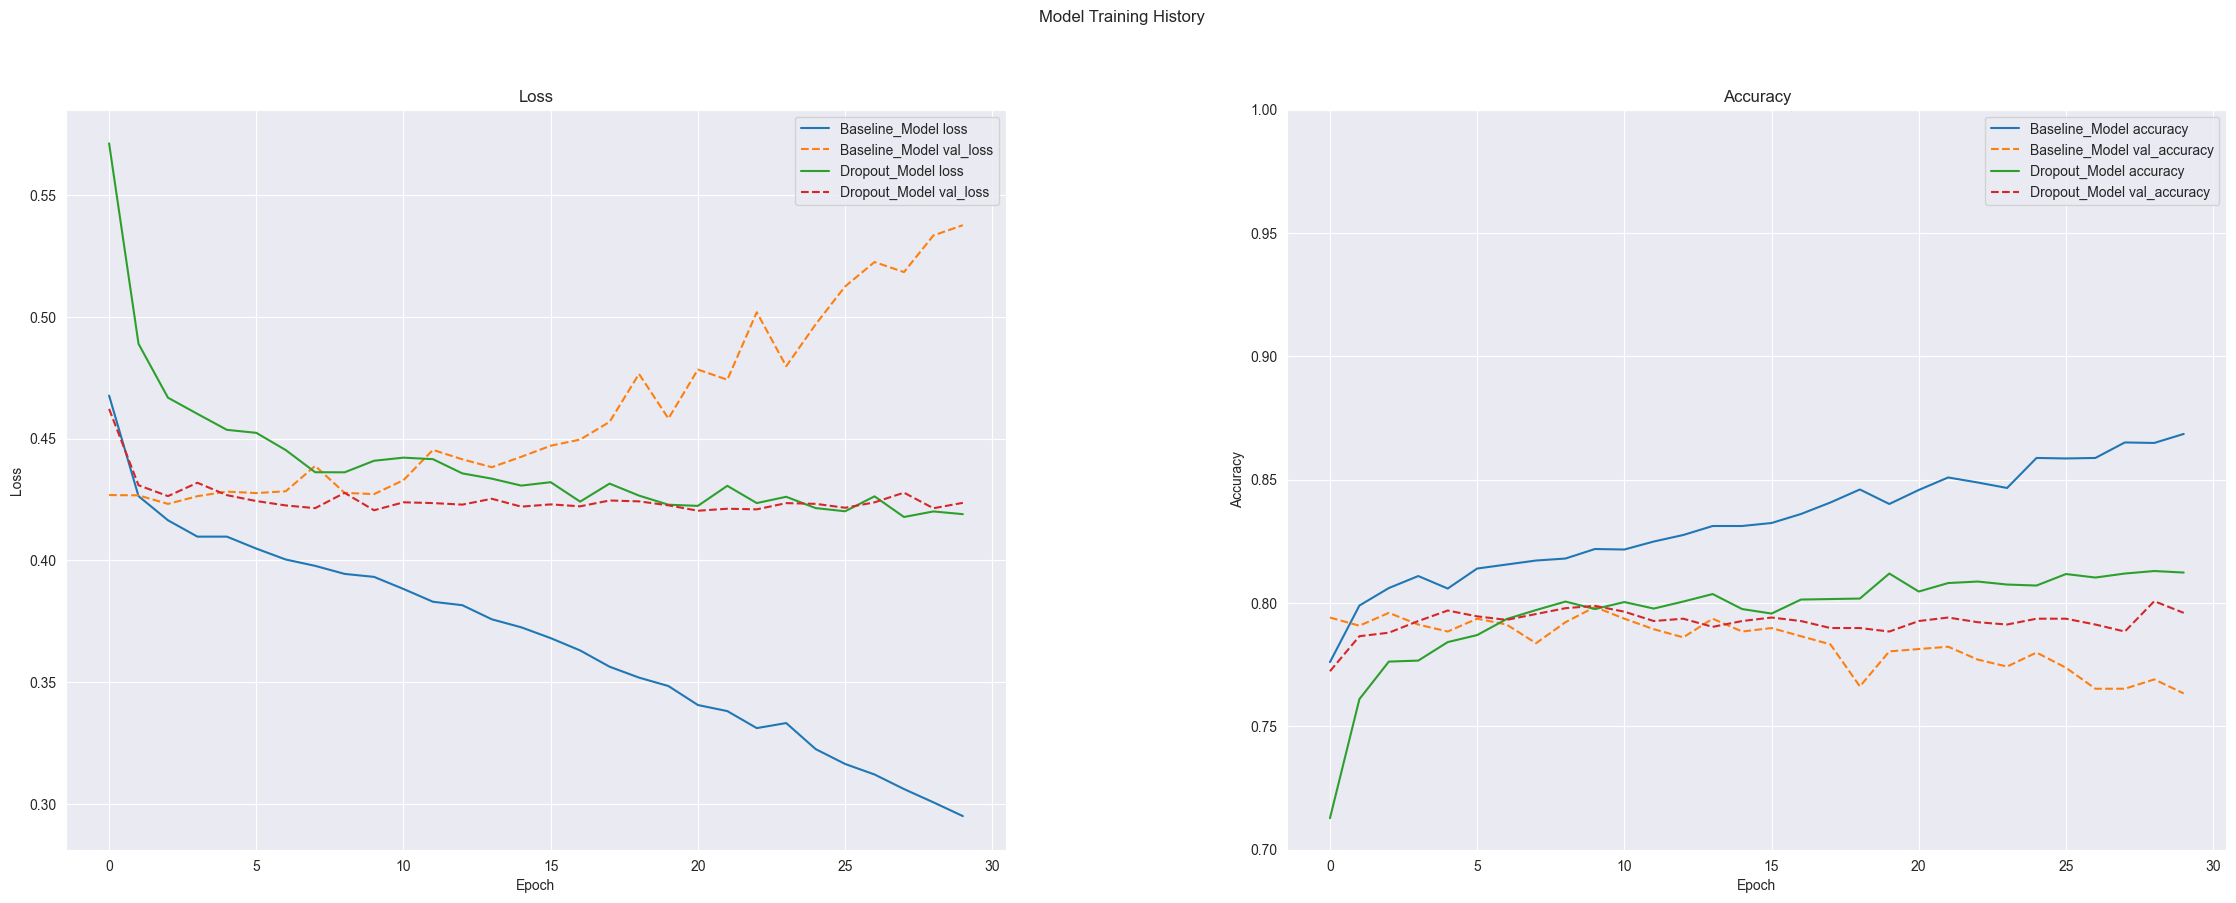

In [36]:
plot_loss_accuracy(
    [
        ('baseline_model', baseline_history),
        ('dropout_model', dropout_history)
    ])


- 각각 결과에 따른 모델의 손실/정확도 비교

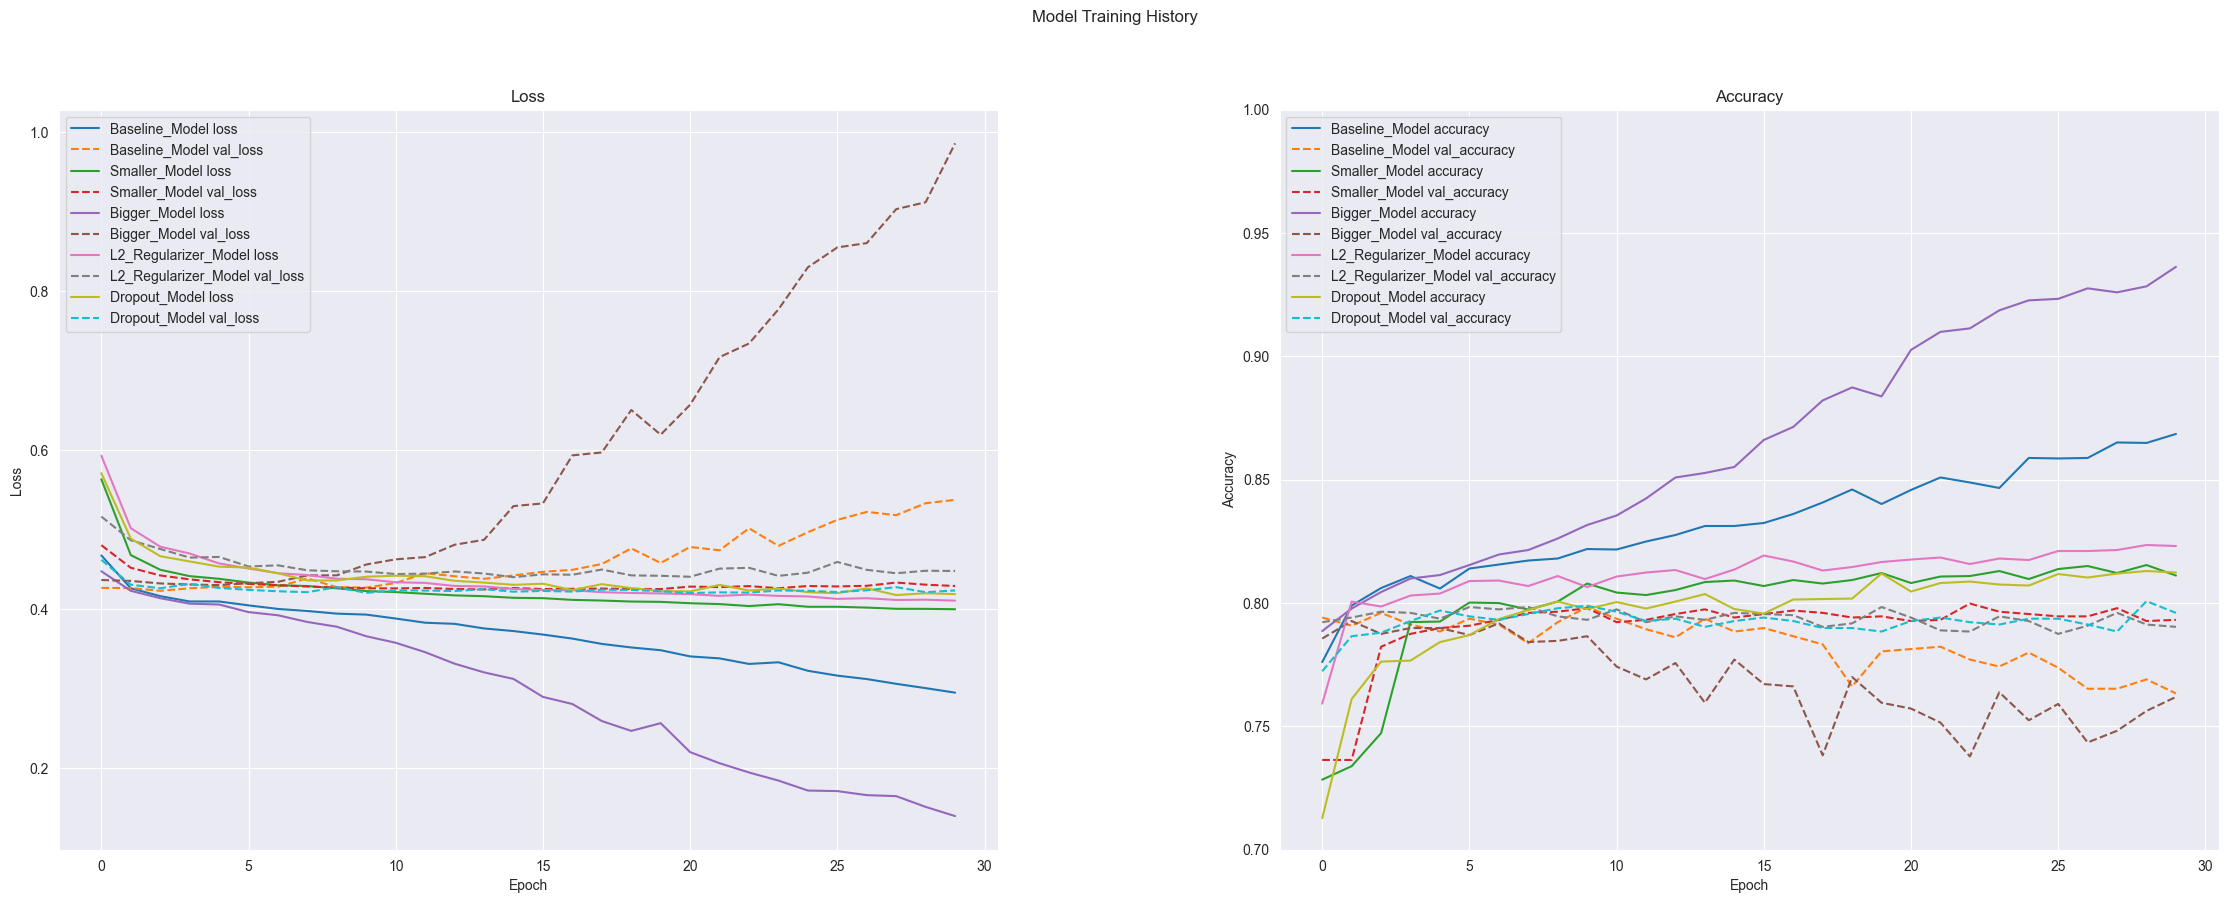

In [37]:
plot_loss_accuracy(
    [
        ('baseline_model', baseline_history),
        ('smaller_model', smaller_history),
        ('bigger_model', bigger_history),
        ('l2_regularizer_model', l2_history),
        ('dropout_model', dropout_history)
    ])